## Notebook for analysing word embeddings

Requires embeddings trained in ```train-w2v.py``` 

In [1]:
from networkx.algorithms.community.kclique import k_clique_communities
from networkx.algorithms.community.centrality import girvan_newman
from networkx import edge_betweenness_centrality
from datetime import datetime, timedelta, date
from gensim.models import KeyedVectors
from collections import OrderedDict
from collections import Counter
import matplotlib.pyplot as plt
from itertools import islice
from itertools import cycle
from glob import glob as gb
from matplotlib import cm
from functions import *
from tqdm import tqdm
import seaborn as sns 
import networkx as nx
import re, string,os
import pandas as pd
import subprocess
import community
import math

plotting.style_()

In [39]:
# Find Most Similar Terms

word_dict = {'gb':'expert','nl':'expert','it':'esperto','pl':'ekspert','dk':'ekspert','es':'experto'}

d = pd.DataFrame()
for iso in ['pl','it','nl','gb','es','dk']:
    for subcorpus in ["reference","covid"]:
        mc = KeyedVectors.load_word2vec_format(f'/home/ruben/Documents/GitHub/ParlaMintCase/results/models/{iso}-{subcorpus}.bin',binary=True)
        if word_dict[iso] in set(mc.vocab):
            ms = mc.wv.most_similar(word_dict[iso],topn=15)
            ms = [x[0] for x in ms]
            # if subcorpus == 'covid':
            #     unique_covid = set(ms) - set(d[f"{iso}-reference"])
            #     ms = [f"{x} (U)" if x in unique_covid else x for x in ms]
            d[f"{iso}-{subcorpus}"] = ms
        else:
            continue
d.to_csv('/home/ruben/Documents/GitHub/ParlaMintCase/results/tables/mostsimilar-covidref.csv',index=False)

<ipython-input-39-7a721e5c84f9>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word_dict[iso] in set(mc.wv.vocab):
<ipython-input-39-7a721e5c84f9>:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  ms = mc.wv.most_similar(word_dict[iso],topn=15)


In [2]:
# Functions for drawing lexical networks based on word embeddings

def get_network_3(model, word, n):

    """ Function to create source > target DataFrame
    model (<gensim.Word2vec> object): word2vec model
    word (str): keyword
    n (int): number of words to consider
    """

    dft = pd.DataFrame()
    for wl1 in list(dict(model.most_similar(word, topn=n)).keys()):
        for wl2 in list(dict(model.most_similar(wl1, topn=n)).keys()):
            for wl3 in list(dict(model.most_similar(wl2, topn=n)).keys()):
                source = wl2
                target = wl3
                t = pd.DataFrame([source, target]).T
                dft = dft.append(t)
    dft.columns = ['source', 'target']
    dft['count'] = [model.wv.vocab[w].count for w in list(dft.target)]
    return dft

def plot_(word,iso,subcorpus,number_most_similar=5,iterations=95,k=0.15,figsize=(24,16)):
    
    """ Function for plotting network
    word (str): keyword 
    iso (str): ISO code ofr language
    subcorpus (str): "reference" or "covid"
    number_most_similar (int): number of most similar words 
    iterations (int): iterations for network plot
    k (float): networkx parameter for spread of network
    figsize (tuple): tuple for figsize of figure
    """

    mo = KeyedVectors.load_word2vec_format(f'results/models/{iso}-{subcorpus}.bin',binary=True)
    df = get_network_3(mo,word,number_most_similar)
    g = nx.from_pandas_edgelist(df, source='source', target='target') 
    plt.figure(figsize=figsize)
    layout = nx.spring_layout(g,iterations=iterations,k=k)
    nx.draw_networkx_nodes(g, layout,alpha=0)
    nx.draw_networkx_edges(g, layout, width=2, edge_color="#cccccc",alpha=.75)

    d = dict(g.degree)
    for node, (x, y) in layout.items():
        plt.text(x, y, node, fontsize=math.log(d[node] * 4) * 5, ha='center', va='center')
    plt.title(f"Network for seed term {word.upper()} (Corpus: {iso.upper()}, {subcorpus.upper()})",fontsize=24,pad=20)
    plt.savefig(f'results/plots/embedding-networks/{iso}-{subcorpus}-{word}-network.png',dpi=400,bbox_inches='tight')
    plt.show()

<ipython-input-2-84c1df2634e3>:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  dft['count'] = [model.wv.vocab[w].count for w in list(dft.target)]


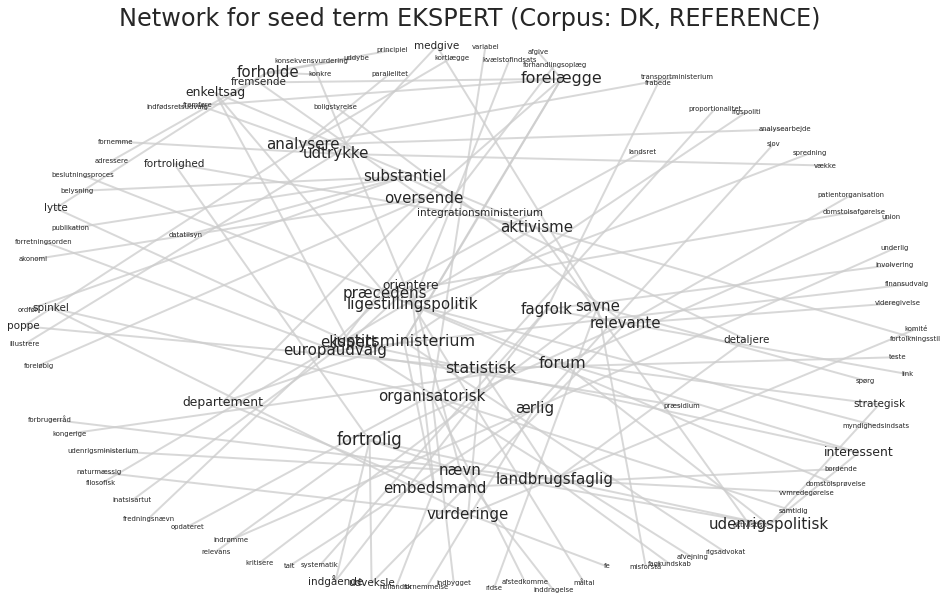

In [6]:
# Draw networks (not in loop because customization)
sns.set_style("white",{"axes.edgecolor":"white"})
plot_('ekspert','dk','reference',number_most_similar=5,iterations=100,k=1.65,figsize=(16,10))